In [41]:
using TrajectoryOptimization
using Plots
using MeshCat
using GeometryTypes
using CoordinateTransformations
using FileIO
using LinearAlgebra
using Pkg

In [72]:
### Solver options ###
opts = SolverOptions()
opts.verbose = true;
opts.square_root = true;
opts.penalty_max = 1.0e8;
opts.outer_loop_update_type=:default;
#opts.outer_loop_update_type=:momentum; #makes very little difference
#opts.outer_loop_update_type=:accelerated; #makes a big difference but seems to overshoot and oscillate (do a linesearch?)
opts.iterations = 500;
opts.constraint_tolerance_coarse = 1e-4;
opts.constraint_tolerance = 1e-4;

In [73]:
# Model
n = 13 # states (quadrotor w/ quaternions)
m = 4 # controls
model = Model(Dynamics.quadrotor_dynamics!,n,m)

TrajectoryOptimization.AbstractModel(TrajectoryOptimization.Dynamics.quadrotor_dynamics!, 13, 4)

In [74]:
# Objective and constraints
Qf = 100.0*Matrix{Float64}(I, n, n)
Q = (1.0)*Matrix{Float64}(I, n, n)
R = (0.1)*Matrix{Float64}(I, m, m)
tf = 5.0
dt = 0.05

# -initial state
x0 = zeros(n)
x0[4:7] = [1;0;0;0]

# -final state
xf = zeros(n)
xf[1:3] = [20.0;20.0;0.0] # xyz position
xf[4:7] = [1;0;0;0]
xf

# -control limits
u_min = -10.0
u_max = 10.0

# -obstacles
quad_radius = 3.0
sphere_radius = 1.0

n_spheres = 4
spheres = ([5.0;9.0;9.0;15.0;],[5.0;9.0;9.0;15.0],[0.0;0.0;4.0;0.0],[sphere_radius;sphere_radius;sphere_radius;sphere_radius])
function cI(x,u)
    [TrajectoryOptimization.sphere_constraint(x,spheres[1][1],spheres[2][1],spheres[3][1],spheres[4][1]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][2],spheres[2][2],spheres[3][2],spheres[4][2]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][3],spheres[2][3],spheres[3][3],spheres[4][3]+quad_radius);
     TrajectoryOptimization.sphere_constraint(x,spheres[1][4],spheres[2][4],spheres[3][4],spheres[4][4]+quad_radius);
     -x[3]]
end

# -constraint that quaternion should be unit
#function cE(x,u)
#    [x[4]^2 + x[5]^2 + x[6]^2 + x[7]^2 - 1.0]
#end

obj_uncon = LQRObjective(Q, R, Qf, tf, x0, xf);
obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max);
#obj_con = TrajectoryOptimization.ConstrainedObjective(obj_uncon, u_min=u_min, u_max=u_max, cI=cI, cE = cE)

In [75]:
# Solver
solver_uncon = Solver(model,obj_uncon,integration=:rk3,dt=dt,opts=opts)
solver = Solver(model,obj_con,integration=:rk3,dt=dt,opts=opts)


# - Initial control and state trajectories
U = (0.5*9.8/4.0).*ones(solver.model.m, solver.N); #Stationary Hover
# X_interp = line_trajectory(solver)

In [76]:
### Solve ###
results, stats = solve(solver,U);
#results, stats = solve(solver_uncon,U);

┌ Info: Solving Constrained Problem...
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/ilqr_methods.jl:267
┌ Info: Outer loop 1 (begin)
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    1     11099.599176  31351.4585              0.998449  0.5       10.00302  31302.83  0e+00     2.711799 1         Inf        0e+00    0          
    2     3157.0566334  7947.76264              0.999343  0.5       5.003836  7942.543  0e+00     4.988156 1         Inf        0e+00    0          
    3     753.21548663  2655.75339           

    26    511.31280849  0.04316148              0.207533  0.5       0.006217  0.008957  0e+00     0.003729 6         Inf        0e+00    0          
    27    511.3100407   0.02592187              0.106774  0.5       0.006188  0.002768  0e+00     0.002593 6         Inf        0e+00    0          
    28    511.30946344  0.02162986              0.026688  0.5       0.006189  0.000577  0e+00     0.001972 6         Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
6         28   6           
┌ Info: Outer loop 7 (begin)
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____-----------------------------------------------------------------

    63    332.53537317  7.39489986              0.519487  0.0625    0.003527  3.841554  0e+00     0.087482 8         Inf        0e+00    0          
    64    325.10052065  8.47262779              0.877514  0.125     0.003696  7.434853  0e+00     0.111606 8         Inf        0e+00    0          
    65    323.54590219  2.38331446              0.652293  0.03125   0.003733  1.554618  0e+00     0.095107 8         Inf        0e+00    0          
    66    319.35918239  5.68816408              0.736041  0.125     0.003876  4.18672   0e+00     0.094562 8         Inf        0e+00    0          
    67    317.91792436  2.27124781              0.634567  0.03125   0.003907  1.441258  0e+00     0.100938 8         Inf        0e+00    0          
    68    317.64132577  0.28118487              0.983689  0.007813  0.003915  0.276599  0e+00     0.075906 8         Inf        0e+00    0          
    69    317.50917533  0.13273564              0.995591  0.003906  0.003918  0.13215   0e+00     0.072086

    103  -88195.567602  2433.30851              0.572107  0.125     0.021236  1392.112  0e+00     0.109939 9         Inf        0e+00    0          
    104  -89089.612793  1088.74839              0.821168  0.0625    0.021722  894.0452  0e+00     0.167617 9         Inf        0e+00    0          
    105  -91007.604589  1895.14804              1.012054  0.125     0.022634  1917.992  0e+00     0.128963 9         Inf        0e+00    0          
    106  -91745.123764  1448.72606              0.509081  0.125     0.023431  737.5192  0e+00     0.07768  9         Inf        0e+00    0          
    107  -92279.086329  657.250442              0.812419  0.0625    0.02378   533.9626  0e+00     0.4642   9         Inf        0e+00    0          
    108  -92962.112368  592.585112              1.152621  0.0625    0.024107  683.026   0e+00     0.246507 9         Inf        0e+00    0          
    109  -93076.572285  987.686391              0.115887  0.125     0.024721  114.4599  0e+00     0.128392

    147  -96252.505609  6.90856508              1.020102  0.003906  0.027387  7.047439  0e+00     0.49425  9         Inf        0e+00    0          
    148  -96259.491581  6.84828335              1.020106  0.003906  0.027393  6.985972  0e+00     0.49186  9         Inf        0e+00    0          
    149  -96266.416218  6.78861629              1.020037  0.003906  0.027399  6.924638  0e+00     0.489471 9         Inf        0e+00    0          
    150  -96273.279714  6.72956085              1.019902  0.003906  0.027406  6.863496  0e+00     0.487249 9         Inf        0e+00    0          
    151  -96280.082316  6.67111366              1.01971   0.003906  0.027412  6.802602  0e+00     0.485215 9         Inf        0e+00    0          
    152  -96286.824323  6.61327084              1.019466  0.003906  0.027418  6.742007  0e+00     0.483085 9         Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad     

    192  -96809.264432  5.14065006              0.867532  0.007813  0.028162  4.45968   0e+00     0.250805 9         Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    193  -96813.388882  5.0400204               0.81834   0.007813  0.028169  4.124449  0e+00     0.263004 9         Inf        0e+00    0          
    194  -96817.797552  4.9509679               0.890466  0.007813  0.028175  4.40867   0e+00     0.304424 9         Inf        0e+00    0          
    195  -96821.826662  4.8520096               0.8304    0.007813  0.028182  4.02911   0e+00     0.286427 9         Inf        0e+00    0          
    19

    235  -5316.5884581  3727.58614              0.388359  0.03125   0.014656  1447.64   0e+00     0.617168 10        Inf        0e+00    0          
    236  -6513.3907815  3639.27042              0.328858  0.03125   0.014678  1196.802  0e+00     0.453855 10        Inf        0e+00    0          
    237  -6536.2207834  3564.87667              0.006404  0.03125   0.015438  22.83     0e+00     0.563453 10        Inf        0e+00    0          
    238  -7814.0470846  3564.66432              0.35847   0.03125   0.01577   1277.826  0e+00     0.374647 10        Inf        0e+00    0          
    239  -9041.0830139  3483.60044              0.352232  0.03125   0.016048  1227.036  0e+00     0.567161 10        Inf        0e+00    0          
    240  -10648.826172  3411.04801              0.471334  0.03125   0.016191  1607.743  0e+00     0.368244 10        Inf        0e+00    0          
    241  -12299.272882  1666.86131              0.990152  0.015625  0.01596   1650.447  0e+00     1.100757

    279  -60656.233637  59.8160614              0.757264  0.007813  0.020199  45.29655  0e+00     0.418496 10        Inf        0e+00    0          
    280  -60722.350804  115.069555              0.574584  0.015625  0.020233  66.11717  0e+00     0.787058 10        Inf        0e+00    0          
    281  -60751.85099   57.7312058              0.510992  0.007813  0.02025   29.50019  0e+00     0.447792 10        Inf        0e+00    0          
    282  -60808.314592  55.4205069              1.018821  0.007813  0.020267  56.4636   0e+00     0.88841  10        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    28

    324  -63223.468749  18.3582603              3.068137  0.007813  0.021299  56.32566  0e+00     0.661251 10        Inf        0e+00    0          
    325  -63381.106066  154.426686              1.020791  0.0625    0.021369  157.6373  0e+00     0.36734  10        Inf        0e+00    0          
    326  -63442.795806  68.2711776              0.903599  0.03125   0.021402  61.68974  0e+00     0.402775 10        Inf        0e+00    0          
    327  -63462.139078  31.5633715              0.612839  0.015625  0.021418  19.34327  0e+00     0.308409 10        Inf        0e+00    0          
    328  -63474.464617  14.5499788              0.847117  0.007813  0.021426  12.32554  0e+00     0.777366 10        Inf        0e+00    0          
    329  -63479.01778   27.6607294              0.164607  0.015625  0.021442  4.553163  0e+00     0.639164 10        Inf        0e+00    0          
    330  -63501.206013  30.9163247              0.717687  0.015625  0.021457  22.18823  0e+00     0.263415

    369  -63722.755563  9.74509299              0.111148  0.007813  0.021734  1.083146  0e+00     0.374328 10        Inf        0e+00    0          
    370  -63728.474416  10.9917452              0.520286  0.007813  0.021739  5.718853  0e+00     0.231823 10        Inf        0e+00    0          
    371  -63732.270869  8.2341288               0.461063  0.007813  0.021744  3.796453  0e+00     0.510819 10        Inf        0e+00    0          
    372  -63736.263563  10.6451112              0.375073  0.007813  0.02175   3.992694  0e+00     0.252638 10        Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
10        372  150         
┌ Info: Outer loop 11 (begin)
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/solve.jl:175
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         m

    411  -44235.564754  1400.45841              0.901697  0.03125   0.017278  1262.789  0e+00     0.332585 11        Inf        0e+00    0          
    412  -44503.040881  661.94379               0.404077  0.015625  0.017407  267.4761  0e+00     1.100539 11        Inf        0e+00    0          
    iter cost          expected    actual      z         α         c_max     dJ        ρ         grad      j         max_cn    min_eig   zero_count info                                              
____--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    413  -44697.069387  328.931944              0.589874  0.007813  0.01747   194.0285  0e+00     0.622808 11        Inf        0e+00    0          
    414  -45082.51519   322.868792              1.193816  0.007813  0.017533  385.4458  0e+00     1.335235 11        Inf        0e+00    0          
    41

    454  -57178.296328  265.900015              0.187016  0.015625  0.020799  49.72747  0e+00     0.487338 11        Inf        0e+00    0          
    455  -57192.500634  65.1161666              0.218138  0.003906  0.020817  14.20431  0e+00     0.8626   11        Inf        0e+00    0          
    456  -57330.21105   124.772596              1.103691  0.007813  0.020854  137.7104  0e+00     0.870225 11        Inf        0e+00    0          
    457  -57643.443629  257.828558              1.214887  0.015625  0.020927  313.2326  0e+00     0.406053 11        Inf        0e+00    0          
    458  -58610.3897    497.852438              1.942234  0.03125   0.021071  966.9461  0e+00     0.626247 11        Inf        0e+00    0          
    459  -59149.808461  217.260136              2.482824  0.015625  0.02114   539.4188  0e+00     0.706465 11        Inf        0e+00    0          
    460  -59227.608089  404.099578              0.192526  0.03125   0.021277  77.79963  0e+00     0.574161

    497  -62438.458879  24.5988815              0.56486   0.003906  0.022784  13.89492  0e+00     0.941698 11        Inf        0e+00    0          
    498  -62476.470258  43.9890126              0.864111  0.007813  0.022806  38.01138  0e+00     0.825616 11        Inf        0e+00    0          
    499  -62514.251868  48.6387722              0.77678   0.007813  0.022827  37.78161  0e+00     0.455906 11        Inf        0e+00    0          
    500  -62627.605632  95.9924766              1.180861  0.015625  0.022869  113.3538  0e+00     0.492986 11        Inf        0e+00    0          
outeriter iter iterations  info                                    
-------------------------------------------------------------------
11        500  128         
┌ Info: ***Solve Complete***
└ @ TrajectoryOptimization /Users/zacman/.julia/dev/TrajectoryOptimization/src/solve.jl:376


In [22]:
### Results ###
println("Final position: $(results.X[end][1:3])\n       desired: $(obj_uncon.xf[1:3])\n    Iterations: $(stats["iterations"])\n Max violation: $(max_violation(results))")

Final position: [19.9999, 19.9999, -9.90088e-5]
       desired: [20.0, 20.0, 0.0]
    Iterations: 100
 Max violation: 0.0014047802779476593


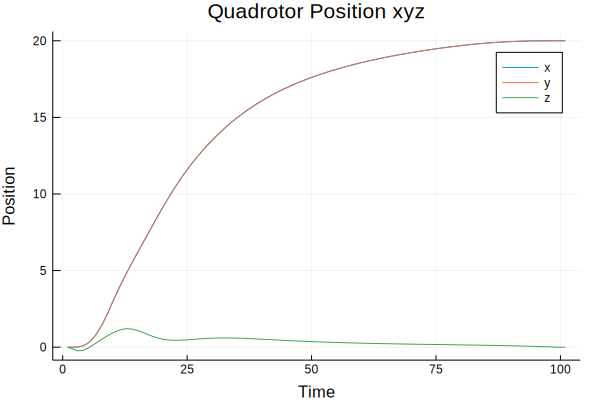

In [23]:
# Position
xhist = hcat(results.X...)
plot(xhist[1:3,:]',title="Quadrotor Position xyz",xlabel="Time",ylabel="Position",label=["x";"y";"z"])

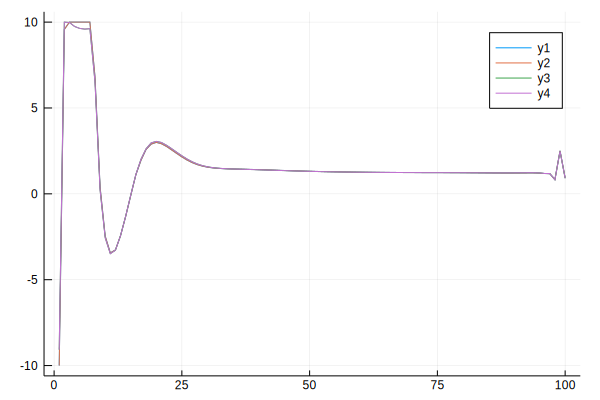

In [24]:
# Control
uhist = hcat(results.U...)
plot(uhist')

Quaternion Animation

In [ ]:
### Visualizer using MeshCat and GeometryTypes ###
# Set up visualizer
vis = Visualizer()
open(vis)

# Import quadrotor obj file
urdf_folder = joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf")
# urdf = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor.urdf")
obj = joinpath(joinpath(Pkg.dir("TrajectoryOptimization"), "dynamics/urdf"), "quadrotor_base.obj")

# color options
green = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))
red = MeshPhongMaterial(color=RGBA(1, 0, 0, 1.0))
blue = MeshPhongMaterial(color=RGBA(0, 0, 1, 1.0))
orange = MeshPhongMaterial(color=RGBA(233/255, 164/255, 16/255, 1.0))
black = MeshPhongMaterial(color=RGBA(0, 0, 0, 1.0))
black_transparent = MeshPhongMaterial(color=RGBA(0, 0, 0, 0.1))

# geometries
robot_obj = load(obj)
sphere_small = HyperSphere(Point3f0(0), convert(Float32,0.03*quad_radius)) # trajectory points
sphere_medium = HyperSphere(Point3f0(0), convert(Float32,quad_radius))

#obstacles = vis["obs"]
traj = vis["traj"]
target = vis["target"]
robot = vis["robot"]

# Set camera location
settransform!(vis["/Cameras/default"], compose(Translation(25., -5., 10),LinearMap(RotZ(-pi/4))))

# Create and place obstacles
#for i = 1:n_spheres
#    setobject!(vis["obs"]["s$i"],HyperSphere(Point3f0(0), convert(Float32,spheres[4][i])),red)
#    settransform!(vis["obs"]["s$i"], Translation(spheres[1][i], spheres[2][i], spheres[3][i]))
#end

# Create and place trajectory
for i = 1:solver.N
    setobject!(vis["traj"]["t$i"],sphere_small,blue)
    settransform!(vis["traj"]["t$i"], Translation(xhist[1,i], xhist[2,i], xhist[3,i]))
end

In [ ]:
# Create and place initial position
setobject!(vis["robot"]["ball"],sphere_medium,black_transparent)
setobject!(vis["robot"]["quad"],robot_obj,black)
settransform!(vis["robot"],compose(Translation(xhist[1,1], xhist[2,1], xhist[3,1]),LinearMap(TrajectoryOptimization.quat2rot(xhist[4:7,1]))))

In [ ]:
# Animate quadrotor
for i = 1:solver.N
    settransform!(vis["robot"], compose(Translation(xhist[1,i], xhist[2,i], xhist[3,i]),LinearMap(TrajectoryOptimization.quat2rot(xhist[4:7,i]))))
    sleep(solver.dt)
end

# # -unconstrained version
# for i = 1:solver.N
#     settransform!(vis["robot"], compose(Translation(results_uncon.X[1,i], results_uncon_euler.X[2,i], results_uncon.X[3,i]),LinearMap(TrajectoryOptimization.quat2rot(results_uncon.X[4:7,i]))))
#     sleep(solver.dt*2)
# end
